In [1]:
#Main method-loading in data, and reshaping:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
import requests
import json
import sys
import os



#loading relevant data:
# Load mapping dictionary
with open(r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Experiments\raw_data\TNBC_set\symbol_to_uniprot.json', 'r') as f:
    symbol_to_uniprot = json.load(f)

print(f"Loaded {len(symbol_to_uniprot)} symbol-to-uniprot mappings")

data=pd.read_csv(
r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Experiments\raw_data\TNBC_set\PTV1_protein_matrix_test.cleaned.tsv',
index_col=0,sep='\t')

viability_raw=pd.read_excel(
r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Experiments\raw_data\TNBC_set\cell_viability_sampleinfo_for_chris.xlsx', 
sheet_name=0)

screen_info = pd.read_excel(
    r"C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Experiments\raw_data\TNBC_set\PTV1_sample_info_test.xlsx", 
    sheet_name=0)  # First sheet is single perturbation info

Loaded 20311 symbol-to-uniprot mappings


In [2]:
#making data_by_cell_line_raw; control_data_by_cell_line; control_data_by_cell_line_coeffvar:
data_T=data.transpose()
data_T['Sample_ID']=data_T.index
data_and_screen_info=pd.merge(data_T,screen_info,on='Sample_ID',how='left')
data_and_screen_info_and_viability = pd.merge(data_and_screen_info, viability_raw, on='Sample_ID', how='left')

#averaging over replicates:(pandas mean ignores NaN's)
#preserving the control rows since they drop out for some reason:
control_rows=data_and_screen_info_and_viability[data_and_screen_info_and_viability['pert_id']=='no']
r_conts = control_rows.copy()
data_and_screen_info_and_viability_grouped = (
    data_and_screen_info_and_viability
    .groupby(['pert_id', 'Cell', 'pert_time_x'])
    .mean(numeric_only=True)
    .reset_index()
)
r_conts.loc[r_conts['pert_id'] == 'no', 'pert_id'] = 'control'
r_conts_grouped_mean=r_conts.groupby(['pert_id', 'cell_line']).mean(numeric_only=True).reset_index()
#dropping unneeded columns:
data_dropped=data_and_screen_info_and_viability_grouped.drop(columns=['BioRep_y','pert_time_y'])

#getting coeff var for control data for filtering:
intermediate=r_conts.groupby(['cell_line']).std(numeric_only=True)
inter_idx=intermediate.index
r_conts_grouped_std=intermediate.reset_index()
coeff_var=r_conts_grouped_std.select_dtypes(include=[float, int])/r_conts_grouped_mean.select_dtypes(include=[float, int])
coeff_var['cell_line']=inter_idx

#dropping the irrelevant timepoints, (6 and 48)
data_dropped=data_dropped[data_dropped['pert_time_x']==24]

#//////////metadata codeblock
# Move the first three columns to the end of data_dropped
first_three_cols = data_dropped.columns[:3]
other_cols = data_dropped.columns[3:]
data_dropped = data_dropped.loc[:, list(other_cols) + list(first_three_cols)]
# Rename the last 10 columns of data_dropped by adding 'meta_' as a prefix
cols = list(data_dropped.columns)
last_9 = cols[-8:]
new_last_9 = ['meta_' + col for col in last_9]
rename_dict = dict(zip(last_9, new_last_9))
data_dropped = data_dropped.rename(columns=rename_dict)
#////////////////////////

#generating the dictionaries by cell line
data_by_cell_line_raw={}
control_data_by_cell_line={}
control_data_by_cell_line_coeffvar={}
cell_lines=pd.unique(data_and_screen_info_and_viability_grouped['Cell'])
for cell in cell_lines:
    data_by_cell_line_raw[cell]=data_dropped[data_dropped['meta_Cell']==cell]
    control_data_by_cell_line[cell]=r_conts_grouped_mean[r_conts_grouped_mean['cell_line']==cell]
    control_data_by_cell_line_coeffvar[cell]=coeff_var[coeff_var['cell_line']==cell]
    control_data_by_cell_line_coeffvar[cell].drop(columns=['cell_line'],inplace=True)


C:\Users\abdul\AppData\Local\Temp\ipykernel_40048\2042579076.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data_by_cell_line_coeffvar[cell].drop(columns=['cell_line'],inplace=True)
C:\Users\abdul\AppData\Local\Temp\ipykernel_40048\2042579076.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data_by_cell_line_coeffvar[cell].drop(columns=['cell_line'],inplace=True)
C:\Users\abdul\AppData\Local\Temp\ipykernel_40048\2042579076.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

(array([5.770e+02, 9.060e+02, 1.243e+03, 1.511e+03, 1.671e+03, 1.786e+03,
        1.921e+03, 1.846e+03, 1.909e+03, 1.780e+03, 1.712e+03, 1.656e+03,
        1.546e+03, 1.384e+03, 1.366e+03, 1.304e+03, 1.145e+03, 1.109e+03,
        1.017e+03, 9.350e+02, 8.380e+02, 7.730e+02, 7.110e+02, 6.040e+02,
        5.830e+02, 5.570e+02, 4.480e+02, 4.020e+02, 3.790e+02, 3.300e+02,
        3.040e+02, 2.570e+02, 2.610e+02, 2.280e+02, 1.780e+02, 1.680e+02,
        1.630e+02, 1.360e+02, 1.390e+02, 1.320e+02, 1.360e+02, 1.060e+02,
        8.300e+01, 7.100e+01, 7.200e+01, 7.000e+01, 4.600e+01, 5.200e+01,
        6.200e+01, 5.600e+01, 5.400e+01, 3.700e+01, 4.500e+01, 3.700e+01,
        2.600e+01, 3.300e+01, 2.400e+01, 2.400e+01, 1.600e+01, 2.000e+01,
        1.600e+01, 2.600e+01, 1.700e+01, 2.100e+01, 1.500e+01, 1.600e+01,
        1.500e+01, 7.000e+00, 6.000e+00, 5.000e+00, 5.000e+00, 7.000e+00,
        5.000e+00, 1.100e+01, 5.000e+00, 2.000e+00, 5.000e+00, 1.000e+00,
        6.000e+00, 2.000e+00, 3.000e+0

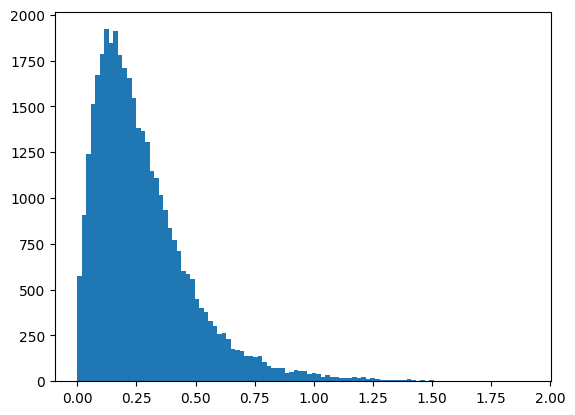

In [3]:
plt.hist(coeff_var.drop(columns=['cell_line']).values.flatten(),bins=100)

In [4]:
#making drug_pert_id_targets_dict
drugs_and_targets = pd.read_csv(
    r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Experiments\raw_data\TNBC_set\ptv1_unique_drug_names.csv'
)
drugs_and_targets.rename(columns={'original_drug_names': 'pert_name'}, inplace=True)
drugs_and_targets.dropna(inplace=True,subset=['pert_name'])

# Read and process drugs_and_pert_ids
drugs_and_pert_ids = pd.read_csv(
    r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Experiments\raw_data\TNBC_set\PTV1_sample_info_test.csv'
)

drugs_and_pert_ids = (
    drugs_and_pert_ids
    .drop_duplicates(subset=['pert_id'])
    .drop_duplicates(subset=['pert_name'])
    .loc[:, ['pert_id', 'pert_name']]
    .assign(pert_id=lambda df: df['pert_id'].str.replace('#', ''))
    .dropna()
    .assign(pert_id=lambda df: df['pert_id'].astype(int))
    .sort_values('pert_id')
    .reset_index(drop=True)
)

# Merge and drop unnecessary columns
drugs_pert_ids_targets = (
    pd.merge(drugs_and_pert_ids, drugs_and_targets, on='pert_name', how='left')
    .drop(columns=['corrected_drug_name', 'drugbank_targets_manual_check'], errors='ignore')
)

# Build dictionary mapping pert_id and pert_name to list of targets
drug_pert_id_targets_dict = {}
for _, row in drugs_pert_ids_targets.iterrows():
    targets = []
    if pd.notnull(row.get('target_uniprot_ids')):
        targets = [t.strip() for t in str(row['target_uniprot_ids']).split(',') if t.strip()]
    drug_pert_id_targets_dict[row['pert_id']] = targets
    drug_pert_id_targets_dict[row['pert_name']] = targets

In [5]:
#making targeted_prots_raw and non_targeted_prots_raw:
graph_flag=False
#Main method-essential filtering:
# graph_flag = False  #set to true to plot in the filter lines
cell_lines=['HS578T','HCC70','BT549','MDA-MB-453','MCF7','DU4475']

#basic completeness filters #TODO graphs are broken but that's fine
targeted_prots_raw={}
non_targeted_prots_raw={}
all_targeted_prots=[item for sublist in drug_pert_id_targets_dict.values() for item in sublist]

for cell in cell_lines:
    meta_cols=data_by_cell_line_raw[cell].columns[data_by_cell_line_raw[cell].columns.str.contains('meta_')]
    intersection=list(set(all_targeted_prots).intersection(set(data_by_cell_line_raw[cell].columns)))


    targeted_prots_raw[cell] = data_by_cell_line_raw[cell][list(intersection) + list(meta_cols)]
    
    non_targeted_prots_raw[cell]=data_by_cell_line_raw[cell].drop(columns=intersection)




filtering incomplete proteins
[cell line: HS578T]  70 cols -> 43 cols
[cell line: HCC70]  70 cols -> 36 cols
[cell line: BT549]  70 cols -> 46 cols
[cell line: MDA-MB-453]  70 cols -> 31 cols
[cell line: MCF7]  70 cols -> 38 cols
[cell line: DU4475]  70 cols -> 34 cols





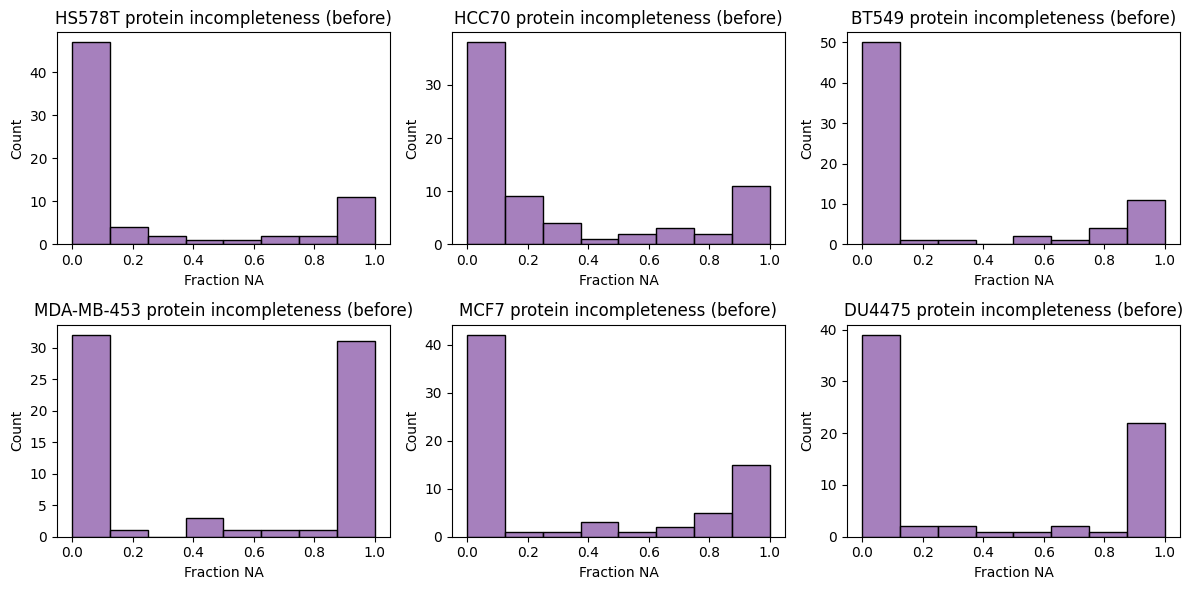

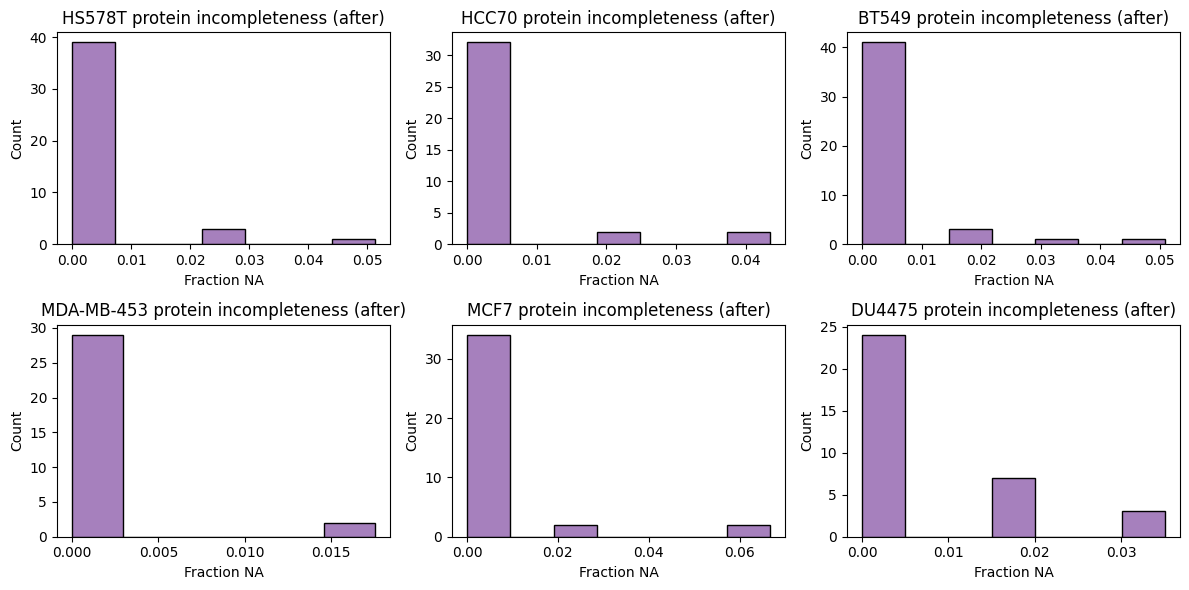

filtering proteins with control values
['Cell Line: ' HS578T]  43 prots -> 43 prots
['Cell Line: ' HCC70]  36 prots -> 36 prots
['Cell Line: ' BT549]  46 prots -> 46 prots
['Cell Line: ' MDA-MB-453]  31 prots -> 28 prots
['Cell Line: ' MCF7]  38 prots -> 36 prots
['Cell Line: ' DU4475]  34 prots -> 33 prots


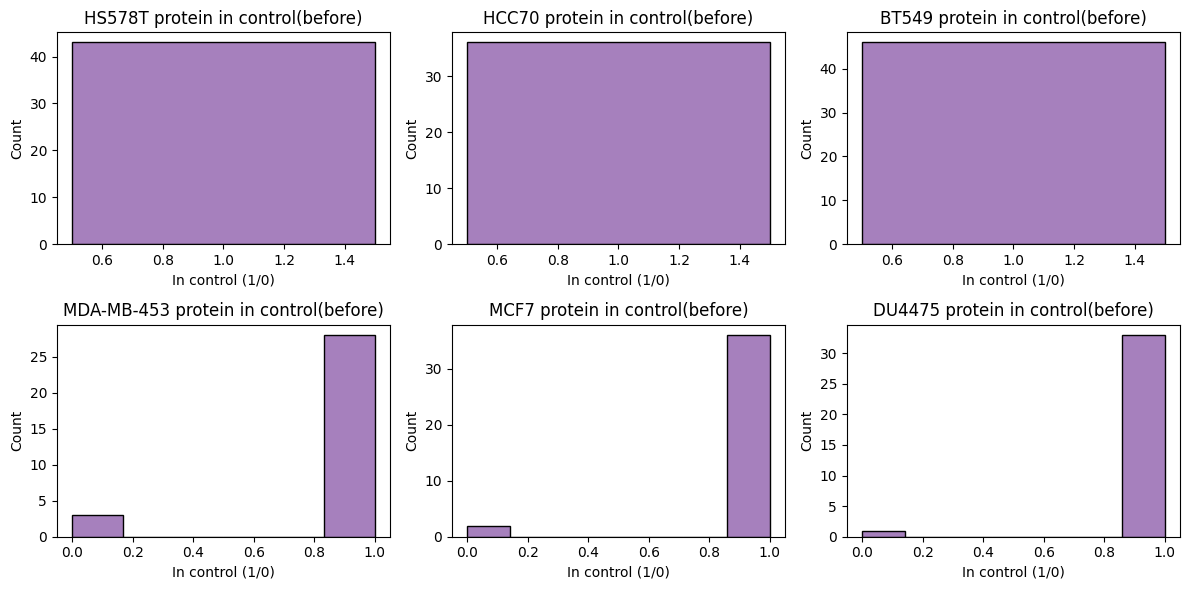

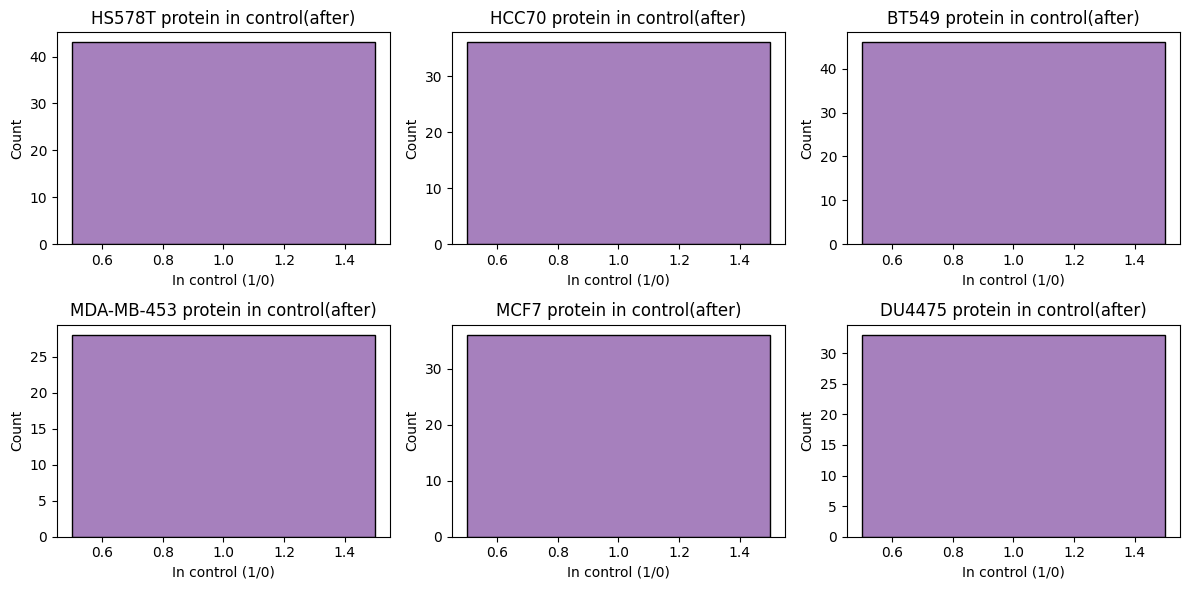

filtering incomplete experiments
[HS578T: ]  39 experiments -> 39 experiments
[HCC70: ]  46 experiments -> 45 experiments
[BT549: ]  59 experiments -> 59 experiments
[MDA-MB-453: ]  57 experiments -> 57 experiments
[MCF7: ]  45 experiments -> 45 experiments
[DU4475: ]  57 experiments -> 56 experiments





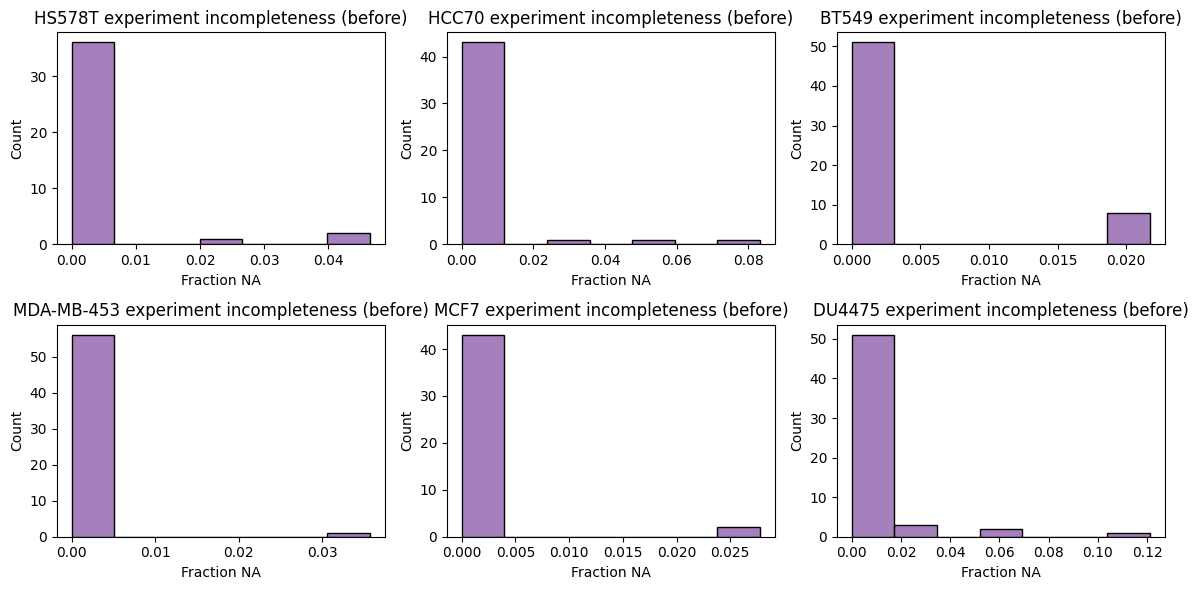

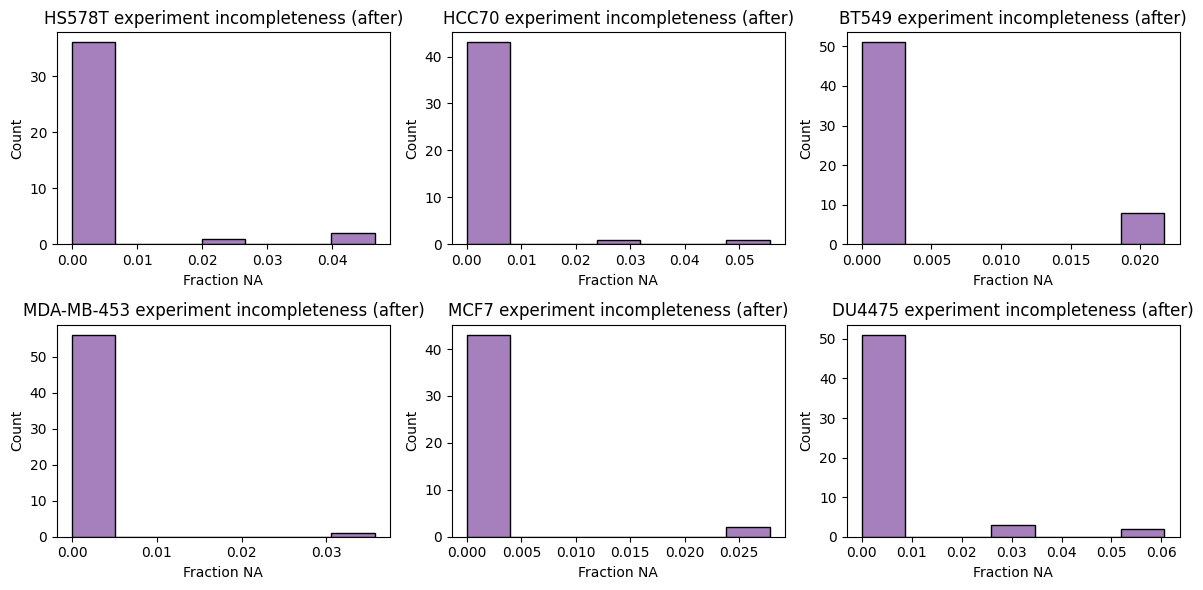

removing outlier proteins
HS578T: started with 41 proteins, filtered to 40 proteins
HCC70: started with 34 proteins, filtered to 34 proteins
BT549: started with 44 proteins, filtered to 43 proteins
MDA-MB-453: started with 26 proteins, filtered to 26 proteins
MCF7: started with 34 proteins, filtered to 34 proteins
DU4475: started with 31 proteins, filtered to 31 proteins





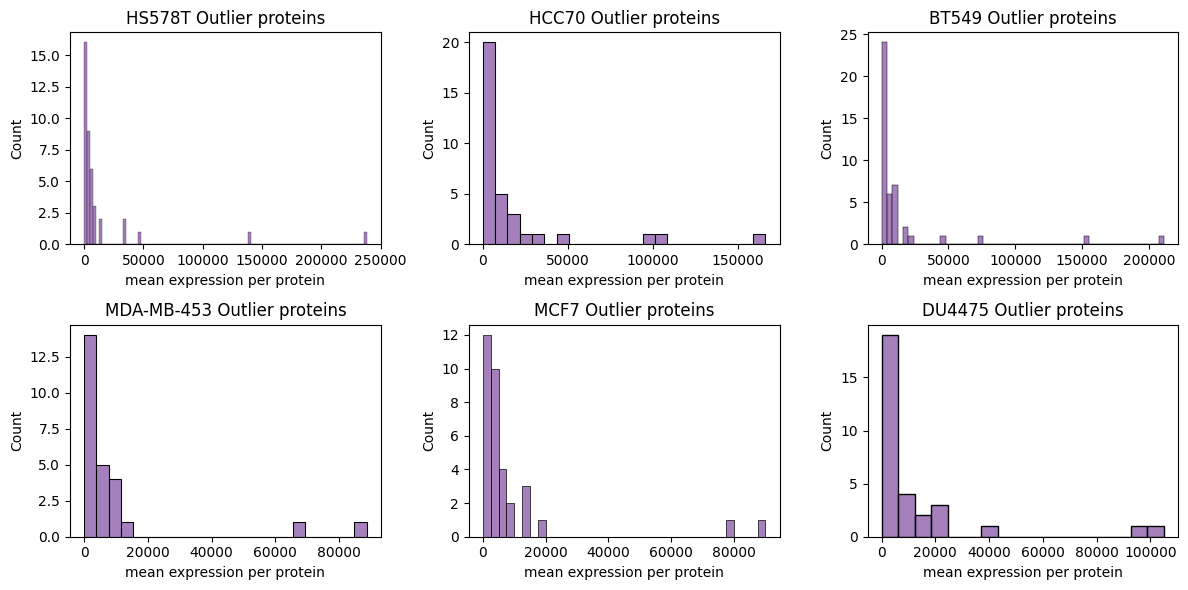

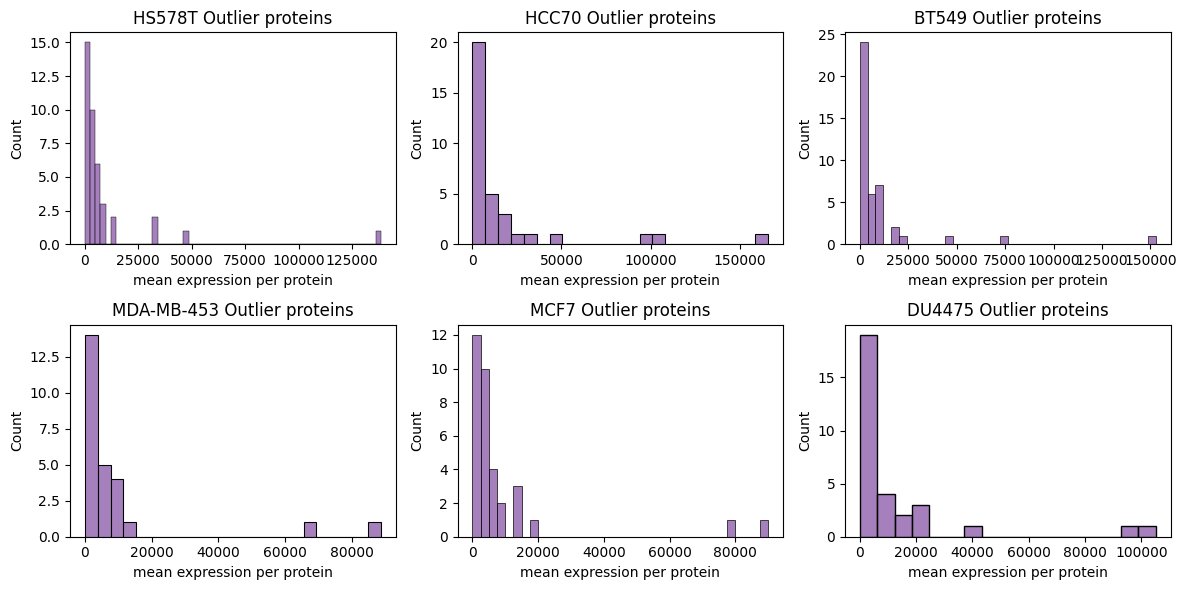

filtering low coefficient of variation proteins
Cell line: HS578T | Filtered from 42 to 42 proteins
Cell line: HCC70 | Filtered from 36 to 34 proteins
Cell line: BT549 | Filtered from 45 to 44 proteins
Cell line: MDA-MB-453 | Filtered from 28 to 11 proteins
Cell line: MCF7 | Filtered from 36 to 29 proteins
Cell line: DU4475 | Filtered from 33 to 29 proteins





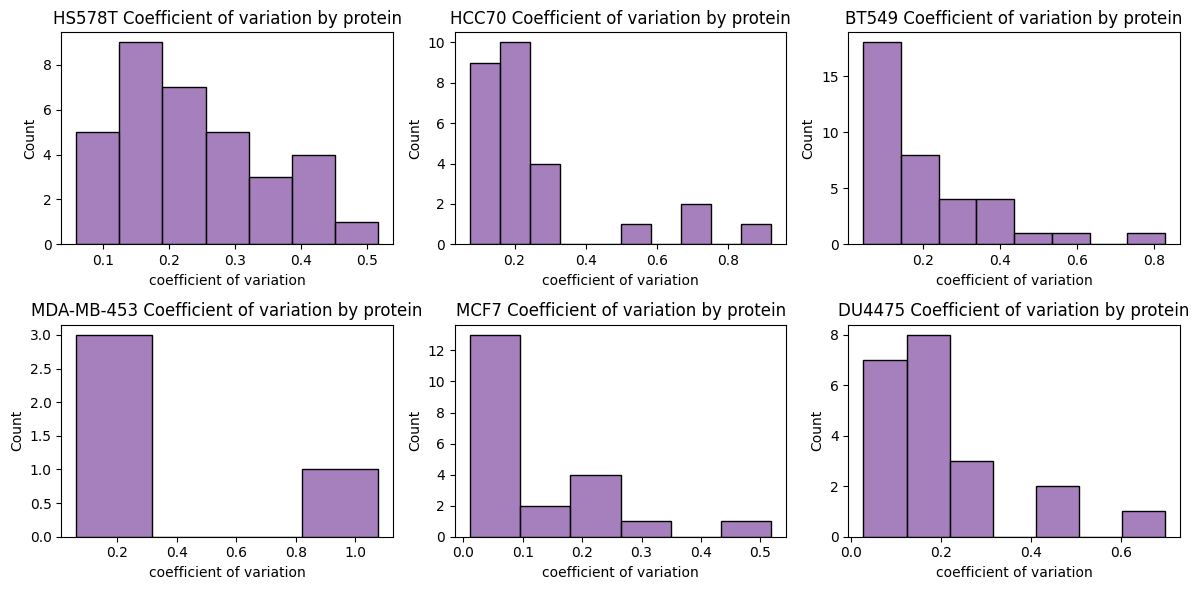

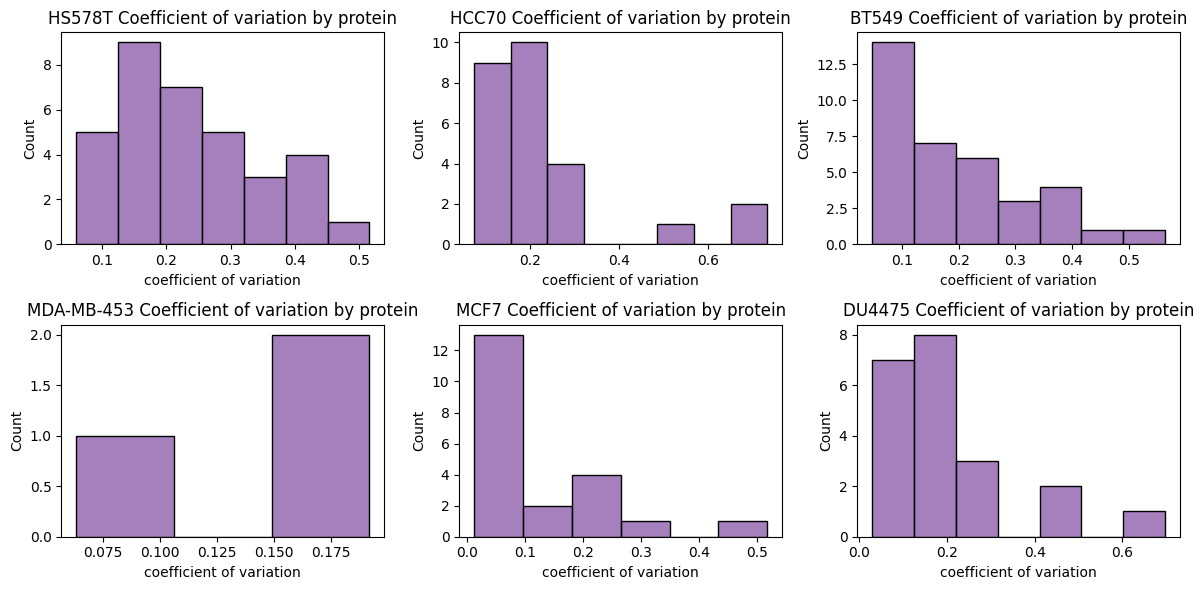

log2 transforming by control



filtering by mutual information
[HS578T] Filtered proteins by mutual information: 42 -> 18
[HCC70] Filtered proteins by mutual information: 34 -> 13
[BT549] Filtered proteins by mutual information: 44 -> 19
[MDA-MB-453] Filtered proteins by mutual information: 11 -> 2
[MCF7] Filtered proteins by mutual information: 29 -> 11
[DU4475] Filtered proteins by mutual information: 29 -> 8


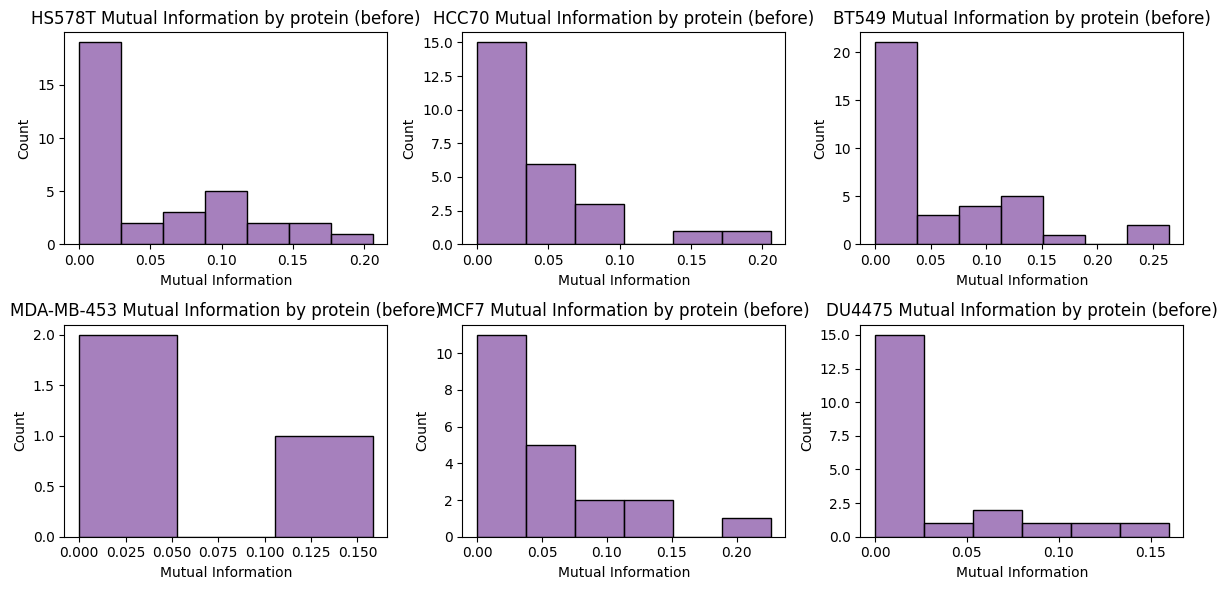

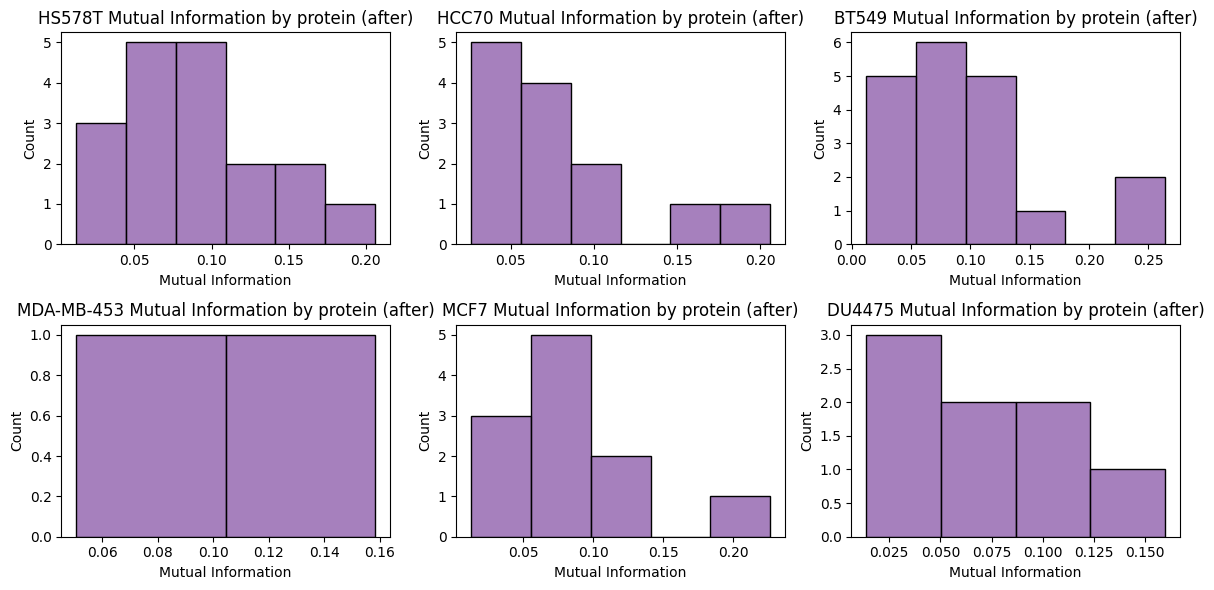




filtering using iterative SNR filtering
[HS578T] Filtered from 18 to 9 signal proteins.
graphing not implemented
[HCC70] Filtered from 13 to 10 signal proteins.
graphing not implemented
[BT549] Filtered from 19 to 16 signal proteins.
graphing not implemented
[MDA-MB-453] Filtered from 2 to 0 signal proteins.
graphing not implemented
[MCF7] Filtered from 11 to 3 signal proteins.
graphing not implemented
[DU4475] Filtered from 8 to 5 signal proteins.
graphing not implemented
graphing not implemented





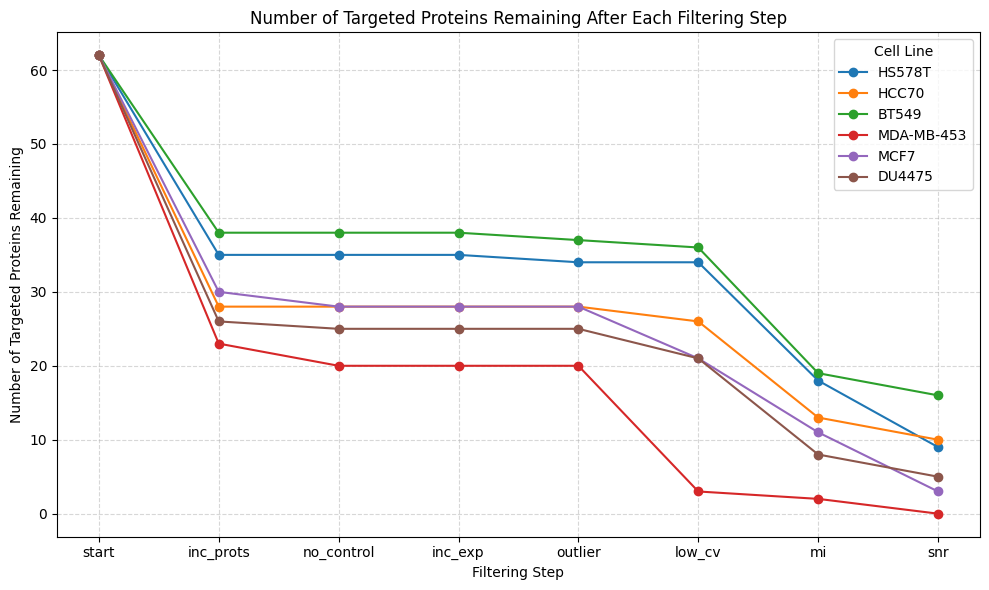

In [ ]:
# Targeted proteins pipeline final_filtered_tgtd_prots
# Part 1: Filtering
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

#functions written by AK:
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.filtering_functions import *
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.graphing_fxns import *
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.making_cellbox_files import *

cell_lines = ['HS578T', 'HCC70', 'BT549', 'MDA-MB-453', 'MCF7', 'DU4475']
config_active = {
    'graph_flag': True,'print_flag': True,'graph_type': 'hist','filter_flag': True}
config_inactive = {
    'graph_flag': False,'print_flag': True,'graph_type': 'hist','filter_flag': False
}


# Define meta columns once, as they are the same for all cell lines
meta_cols = targeted_prots_raw[cell_lines[0]].columns[targeted_prots_raw[cell_lines[0]].columns.str.contains('meta_')]

# Stepwise filtering with explicit step names
step_0_tgtd_prots = targeted_prots_raw
step_1_tgtd_prots = filter_incomplete_proteins(step_0_tgtd_prots, cell_lines, completeness_threshold_prot=0.95, **config_active)
step_2_tgtd_prots = filter_proteins_with_control(step_1_tgtd_prots, control_data_by_cell_line, cell_lines, **config_active)
step_3_tgtd_prots = filter_incomplete_experiments(step_2_tgtd_prots, cell_lines, completeness_threshold_experiment=0.95, **config_active)
step_4_tgtd_prots = remove_outlier_proteins(step_3_tgtd_prots, cell_lines, outlier_factor=10, **config_active)
step_5_tgtd_prots = filter_keep_low_cv(step_4_tgtd_prots, control_data_by_cell_line_coeffvar, cell_lines, max_cv=0.8, **config_active)
step_6_tgtd_prots = log2_transform_by_control(step_5_tgtd_prots, control_data_by_cell_line, cell_lines)
step_7_tgtd_prots = filter_by_mutual_information(step_6_tgtd_prots, cell_lines, mi_thresh=0.01, y_col='meta_Inhi_5', rand_state=42, **config_active)
step_8_tgtd_prots = iterative_signal_filtering(step_7_tgtd_prots, cell_lines, std_threshold=2.5, tole=0.001, filtering_to_use=1, **config_active)

# For targeted proteins, count proteins at each step (excluding meta columns)
num_prots_tgt = pd.DataFrame(index=cell_lines, columns=['start', 'inc_prots', 'no_control', 'inc_exp', 'outlier', 'low_cv', 'mi', 'snr'])
lmc_tgt = len(targeted_prots_raw[cell_lines[0]].columns[targeted_prots_raw[cell_lines[0]].columns.str.contains('meta_')])
for cell in cell_lines:
    num_prots_tgt.loc[cell, 'start'] = step_0_tgtd_prots[cell].shape[1] - lmc_tgt
    num_prots_tgt.loc[cell, 'inc_prots'] = step_1_tgtd_prots[cell].shape[1] - lmc_tgt
    num_prots_tgt.loc[cell, 'no_control'] = step_2_tgtd_prots[cell].shape[1] - lmc_tgt
    num_prots_tgt.loc[cell, 'inc_exp'] = step_3_tgtd_prots[cell].shape[1] - lmc_tgt
    num_prots_tgt.loc[cell, 'outlier'] = step_4_tgtd_prots[cell].shape[1] - lmc_tgt
    num_prots_tgt.loc[cell, 'low_cv'] = step_5_tgtd_prots[cell].shape[1] - lmc_tgt
    num_prots_tgt.loc[cell, 'mi'] = step_7_tgtd_prots[cell].shape[1] - lmc_tgt
    num_prots_tgt.loc[cell, 'snr'] = step_8_tgtd_prots[cell].shape[1] - lmc_tgt

step_counts_tgt = {cell: [num_prots_tgt.loc[cell, step] if step in num_prots_tgt.columns else None for step in ['start', 'inc_prots', 'no_control', 'inc_exp', 'outlier', 'low_cv', 'mi', 'snr']] for cell in cell_lines}
plt.figure(figsize=(10, 6))
filtering_steps = ['start', 'inc_prots', 'no_control', 'inc_exp', 'outlier', 'low_cv', 'mi', 'snr']
for cell in cell_lines:
    plt.plot(filtering_steps, step_counts_tgt[cell], marker='o', label=cell)

plt.xlabel('Filtering Step')
plt.ylabel('Number of Targeted Proteins Remaining')
plt.title('Number of Targeted Proteins Remaining After Each Filtering Step')
plt.legend(title='Cell Line')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

final_filtered_tgtd_prots = step_8_tgtd_prots


filtering incomplete proteins
[cell line: HS578T]  5425 cols -> 2574 cols
[cell line: HCC70]  5425 cols -> 2123 cols
[cell line: BT549]  5425 cols -> 2628 cols
[cell line: MDA-MB-453]  5425 cols -> 1650 cols
[cell line: MCF7]  5425 cols -> 2049 cols
[cell line: DU4475]  5425 cols -> 1691 cols



filtering proteins with control values
['Cell Line: ' HS578T]  2574 prots -> 2574 prots
['Cell Line: ' HCC70]  2123 prots -> 2116 prots
['Cell Line: ' BT549]  2628 prots -> 2628 prots
['Cell Line: ' MDA-MB-453]  1650 prots -> 1379 prots
['Cell Line: ' MCF7]  2049 prots -> 1911 prots
['Cell Line: ' DU4475]  1691 prots -> 1651 prots
filtering incomplete experiments
[HS578T: ]  39 experiments -> 39 experiments
[HCC70: ]  46 experiments -> 42 experiments
[BT549: ]  59 experiments -> 58 experiments
[MDA-MB-453: ]  57 experiments -> 56 experiments
[MCF7: ]  45 experiments -> 44 experiments
[DU4475: ]  57 experiments -> 55 experiments



filtering outlier proteins is disabled
filtering low coefficient

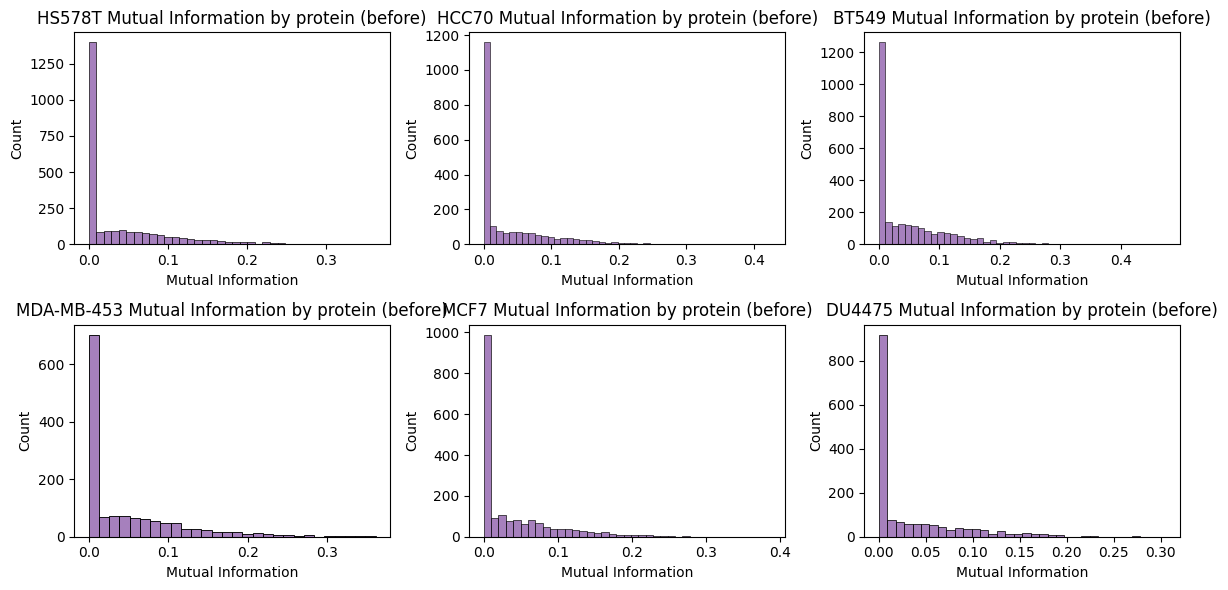

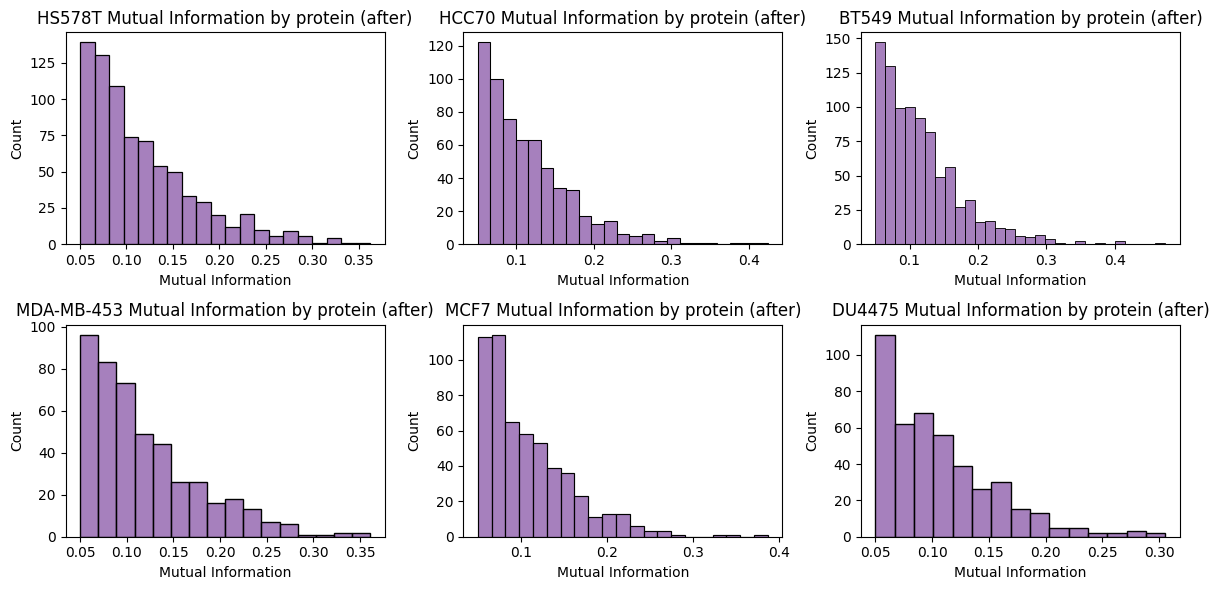




filtering using iterative SNR filtering
[HS578T] Filtered from 780 to 477 signal proteins.
[HCC70] Filtered from 609 to 403 signal proteins.
[BT549] Filtered from 899 to 627 signal proteins.
[MDA-MB-453] Filtered from 463 to 117 signal proteins.
[MCF7] Filtered from 554 to 242 signal proteins.
[DU4475] Filtered from 439 to 217 signal proteins.



filtering by spearman correlation
[HS578T] Filtered proteins by spearman correlation: 477 -> 193
[HCC70] Filtered proteins by spearman correlation: 403 -> 152
[BT549] Filtered proteins by spearman correlation: 627 -> 319
[MDA-MB-453] Filtered proteins by spearman correlation: 117 -> 59
[MCF7] Filtered proteins by spearman correlation: 242 -> 49
[DU4475] Filtered proteins by spearman correlation: 217 -> 54


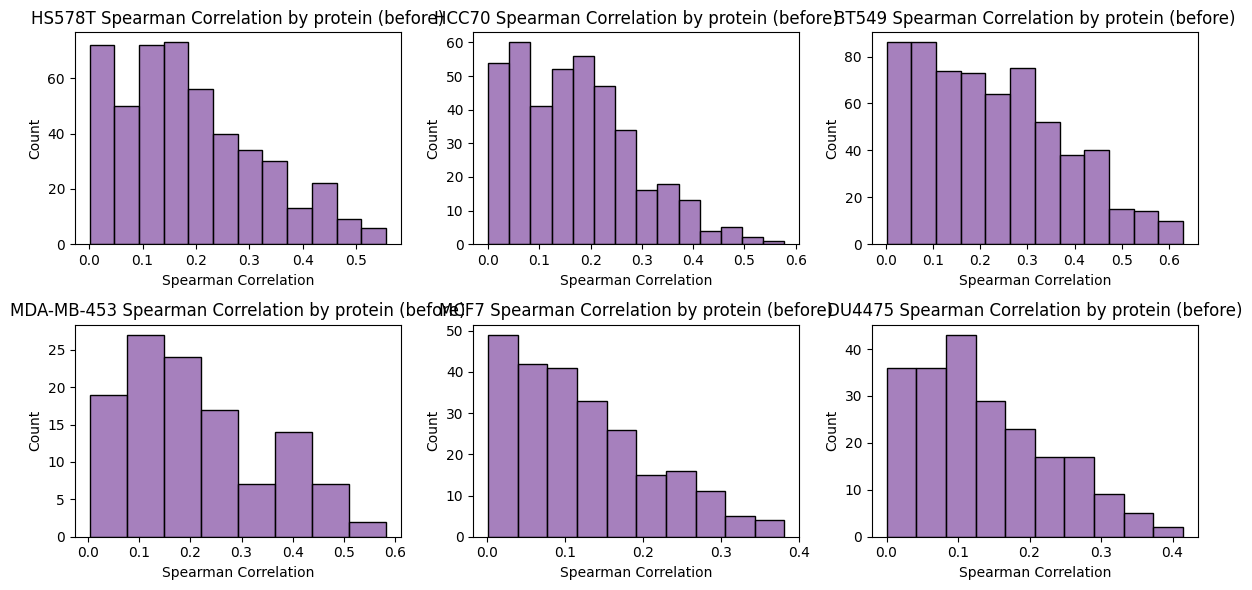

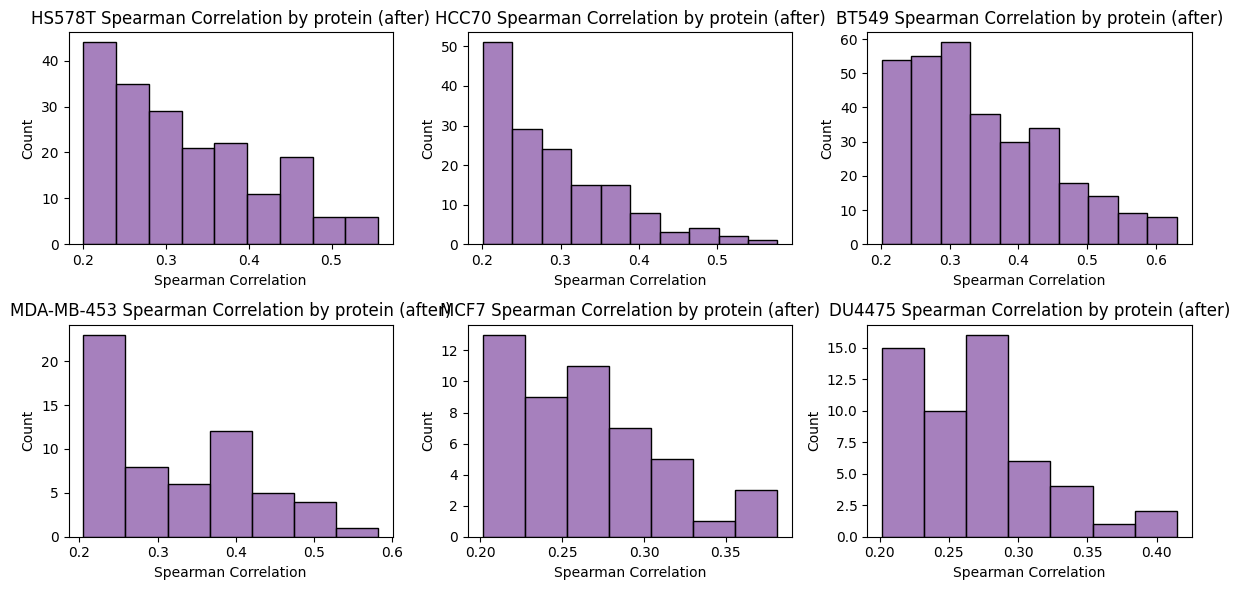




filtering by pearson correlation
[HS578T] Filtered proteins by pearson correlation: 193 -> 147
[HCC70] Filtered proteins by pearson correlation: 152 -> 113
[BT549] Filtered proteins by pearson correlation: 319 -> 266
[MDA-MB-453] Filtered proteins by pearson correlation: 59 -> 50
[MCF7] Filtered proteins by pearson correlation: 49 -> 24
[DU4475] Filtered proteins by pearson correlation: 54 -> 27


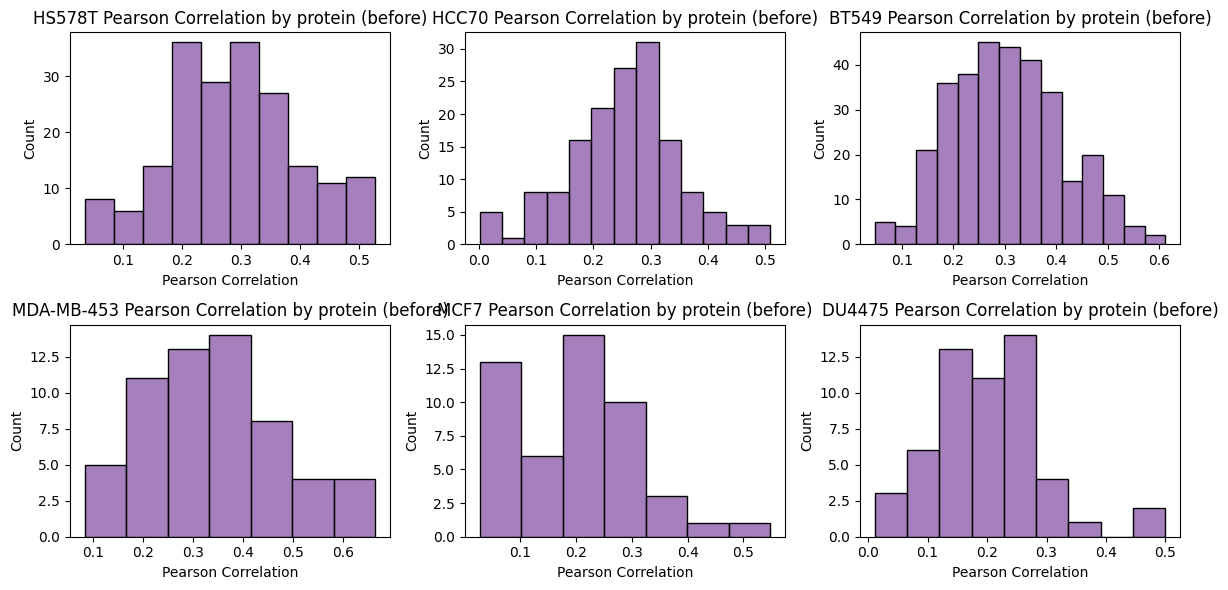

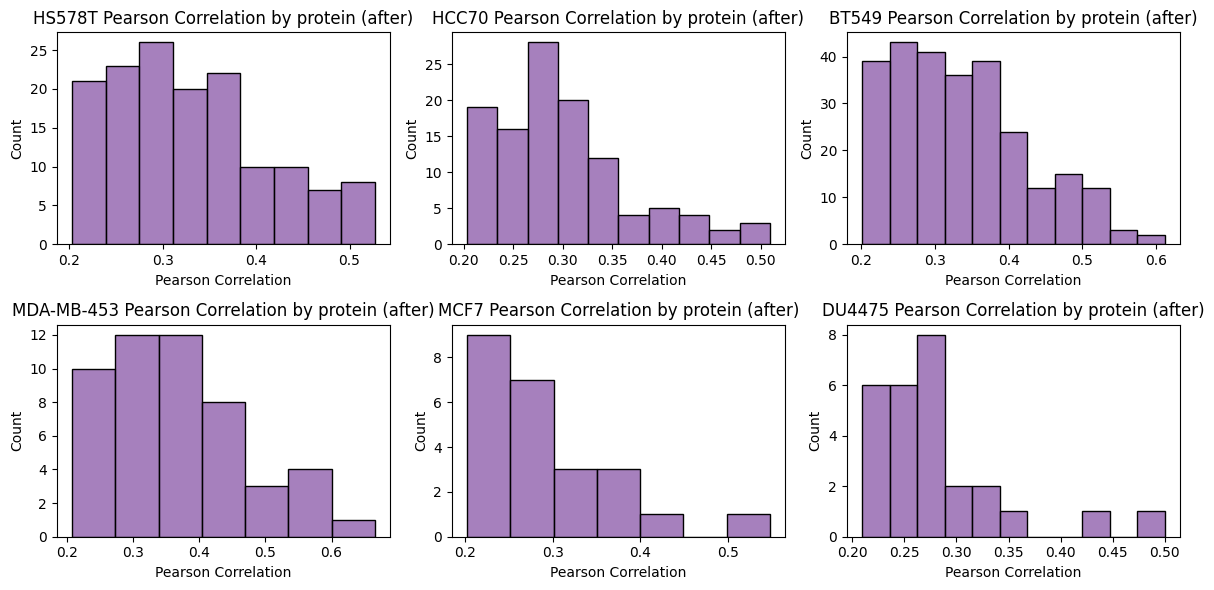

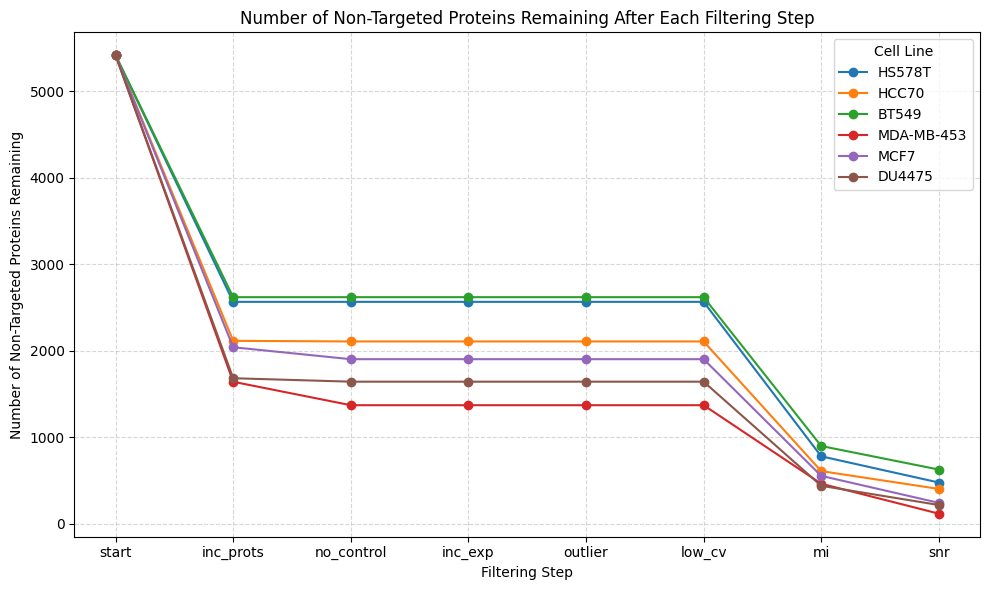

In [12]:
# Non-targeted protein pipeline: final_filtered_non_tgt_prots
cell_lines = ['HS578T', 'HCC70', 'BT549', 'MDA-MB-453', 'MCF7', 'DU4475']
a_config = {
    'graph_flag': False,'print_flag': True,'graph_type': 'hist','filter_flag': True}
ia_config = {
    'graph_flag': False,'print_flag': True,'graph_type': 'hist','filter_flag': False}
graphing_config={
    'graph_flag': True,'print_flag': True, 'graph_type': 'hist', 'filter_flag': True}
#////////////////////////////////////
# Non-targeted protein pipeline:
#////////////////////////////////////
step_0_non_tgt = non_targeted_prots_raw
step_1_non_tgt = filter_incomplete_proteins(step_0_non_tgt, cell_lines, completeness_threshold_prot=0.95, **a_config)
step_2_non_tgt = filter_proteins_with_control(step_1_non_tgt, control_data_by_cell_line, cell_lines, **a_config)
step_3_non_tgt = filter_incomplete_experiments(step_2_non_tgt, cell_lines, completeness_threshold_experiment=0.95, **a_config)
step_4_non_tgt = remove_outlier_proteins(step_3_non_tgt, cell_lines, outlier_factor=10, **ia_config)
step_5_non_tgt = filter_keep_low_cv(step_4_non_tgt, control_data_by_cell_line_coeffvar, cell_lines, max_cv=1, **ia_config)
step_6_non_tgt = log2_transform_by_control(step_5_non_tgt, control_data_by_cell_line, cell_lines)
step_7_non_tgt = filter_by_mutual_information(step_6_non_tgt, cell_lines, mi_thresh=0.05, y_col='meta_Inhi_5', rand_state=42, **graphing_config)
step_8_non_tgt = iterative_signal_filtering(step_7_non_tgt, cell_lines, std_threshold=2.5, tole=0.001, filtering_to_use=1, **a_config)
step_9_non_tgt = spearman_corr_filtering(step_8_non_tgt, cell_lines, ycol='meta_Inhi_5', threshold=0.2, **graphing_config)
step_10_non_tgt = pearson_corr_filtering(step_9_non_tgt, cell_lines, ycol='meta_Inhi_5', threshold=0.2, **graphing_config)

#//////////////////////////////////
# Graph summary for non-targeted proteins filtering (at the end of the pipeline):
#//////////////////////////////////
# For each cell line, collect the number of non-targeted proteins after each step
num_prots_not_tgt = pd.DataFrame(index=cell_lines, columns=['start', 'inc_prots', 'no_control', 'inc_exp', 'outlier', 'low_cv', 'mi', 'snr'])
lmc = len(non_targeted_prots_raw[cell_lines[0]].columns[non_targeted_prots_raw[cell_lines[0]].columns.str.contains('meta_')])
for cell in cell_lines:
    num_prots_not_tgt.loc[cell, 'start'] = step_0_non_tgt[cell].shape[1] - lmc
    num_prots_not_tgt.loc[cell, 'inc_prots'] = step_1_non_tgt[cell].shape[1] - lmc
    num_prots_not_tgt.loc[cell, 'no_control'] = step_2_non_tgt[cell].shape[1] - lmc
    num_prots_not_tgt.loc[cell, 'inc_exp'] = step_3_non_tgt[cell].shape[1] - lmc
    num_prots_not_tgt.loc[cell, 'outlier'] = step_4_non_tgt[cell].shape[1] - lmc
    num_prots_not_tgt.loc[cell, 'low_cv'] = step_5_non_tgt[cell].shape[1] - lmc
    num_prots_not_tgt.loc[cell, 'mi'] = step_7_non_tgt[cell].shape[1] - lmc
    num_prots_not_tgt.loc[cell, 'snr'] = step_8_non_tgt[cell].shape[1] - lmc


step_counts_non_tgt = {cell: [num_prots_not_tgt.loc[cell, step] if step in num_prots_not_tgt.columns else None for step in filtering_steps] for cell in cell_lines}
plt.figure(figsize=(10, 6))
filtering_steps = ['start', 'inc_prots', 'no_control', 'inc_exp', 'outlier', 'low_cv', 'mi', 'snr']
for cell in cell_lines:
    plt.plot(filtering_steps, step_counts_non_tgt[cell], marker='o', label=cell)

plt.xlabel('Filtering Step')
plt.ylabel('Number of Non-Targeted Proteins Remaining')
plt.title('Number of Non-Targeted Proteins Remaining After Each Filtering Step')
plt.legend(title='Cell Line')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

final_filtered_non_tgt_prots = step_10_non_tgt

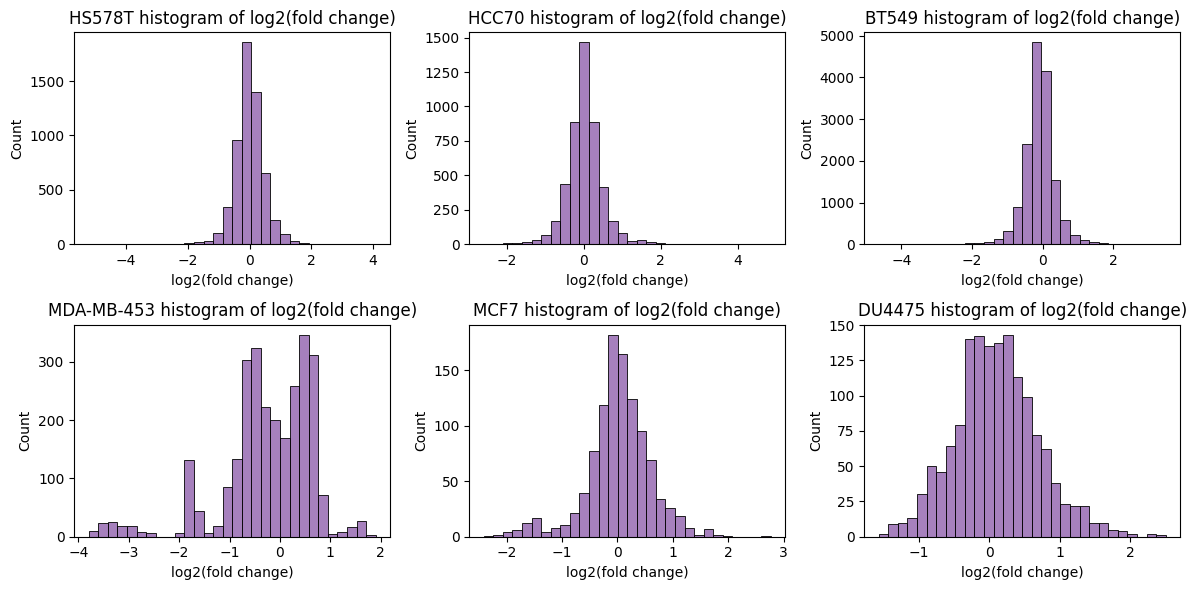

In [8]:
# Example usage:
config2={'bins':30}
x=plot_data_value_distribution(final_filtered_non_tgt_prots, cell_lines, **config2)

Cell line: HS578T | LOO R2: 0.149 | LOO MSE: 0.109 | Pearson: 0.499 | Num features: 147
Cell line: HCC70 | LOO R2: 0.146 | LOO MSE: 0.155 | Pearson: 0.532 | Num features: 113
Cell line: BT549 | LOO R2: 0.510 | LOO MSE: 0.141 | Pearson: 0.726 | Num features: 266
Cell line: MDA-MB-453 | LOO R2: 0.652 | LOO MSE: 0.492 | Pearson: 0.809 | Num features: 50
Cell line: MCF7 | LOO R2: 0.044 | LOO MSE: 0.276 | Pearson: 0.410 | Num features: 24
Cell line: DU4475 | LOO R2: 0.358 | LOO MSE: 0.530 | Pearson: 0.629 | Num features: 27


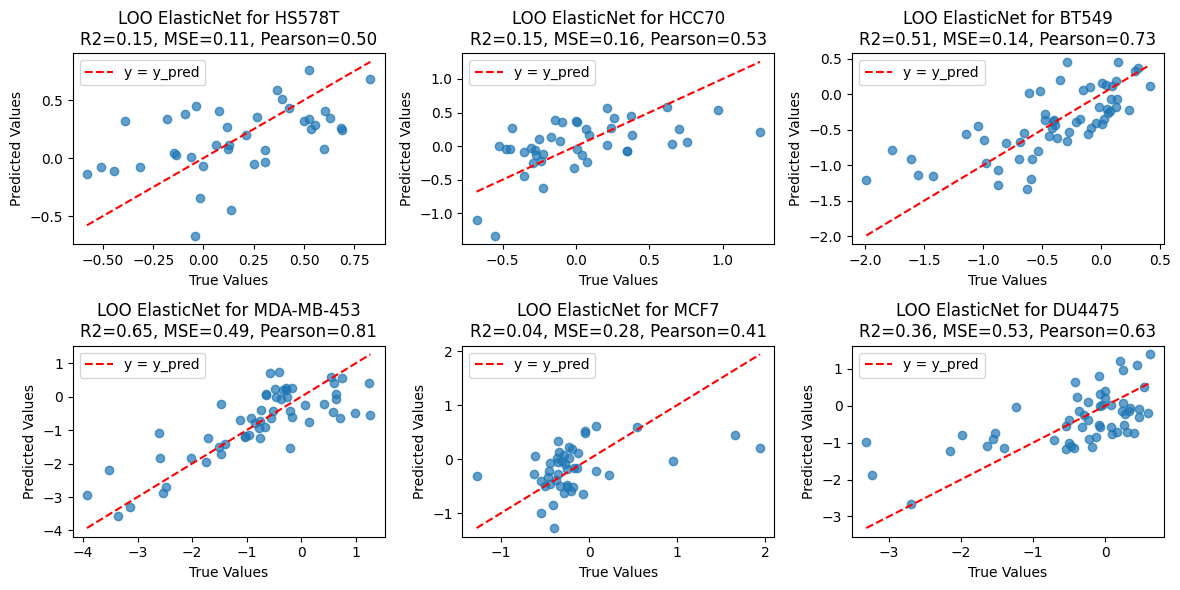

In [11]:
from sklearn.linear_model import ElasticNet

elasticnet_model = ElasticNet(random_state=42, alpha=0.01, l1_ratio=0.5, max_iter=5000)

loo_results = loo_regression_per_cell_line(
    data_by_cell_line=final_filtered_non_tgt_prots,
    ycol='meta_Inhi_5',
    model=elasticnet_model,
    print_stats=True,
    plot_results=True,
    cell_lines=cell_lines
)

In [10]:
#ablation study selection use for the last 200ish proteins;
#cant use because we seem to lack correlation between the cell viability and the proteins.
#have to go back and re-assess the mutual information choice
overlaps={}
overlaps_full_data={}
for i, cell_line in enumerate(cell_lines):
    print(f"Processing cell line: {cell_line}")
    starting_data=final_filtered_non_tgt_prots[cell_line]
    nfeatures=int(100-len(final_filtered_tgtd_prots[cell_line].columns))
    topx_prots=ablation_study(starting_data,
    model='ElasticNet',
    n_features_to_select=nfeatures,
    target_column='meta_Inhi_5',
    verbosity=1
    )
    overlaps[cell_line],overlaps_full_data[cell_line]=overlapping_features(topx_prots,n_prots_to_keep=nfeatures)
    print("\n\n\n")



Processing cell line: HS578T


ValueError: could not convert string to float: '#57'

In [ ]:
#making the final dictionaries of the data:
#add in the proteins named in overlaps[cell_line] (and get data from the non-targeted data) and then add in targeted proteins
#and then preserve viability data
top_100_proteins={}
for cell_line in cell_lines:
    non_tgts=filtered_non_targeted_prots_by_spearman[cell_line].loc[:,overlaps[cell_line]]
    tgts=filtered_targeted_prots[cell_line]
    meta_data=meta_preserved_d3[cell_line][['pert_id','trial names']]
    top_100_proteins[cell_line]=pd.concat([non_tgts,tgts,meta_data],axis=1)


a_test=top_100_proteins[cell_lines[0]]

In [ ]:
sensitive_cell_lines=['HS578T','HCC70','BT549']
for cell_line in sensitive_cell_lines:
    df = top_100_proteins[cell_line]
    output_path = Path(f"{cell_line}_top_100_data.csv")
    df.to_csv(output_path, sep=",")
    print(f"Saved sensitive cell line data for {cell_line} to {output_path}")

In [ ]:
# Plot histograms of data value distribution and column variance for each sensitive cell line

for cell_line in sensitive_cell_lines:
    df = top_100_proteins[cell_line].drop(columns=['pert_id','trial names','Inhi_5'])
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Histogram of all data values
    data_values = df.values.flatten()
    mean_data = data_values.mean()
    axes[0].hist(data_values, bins=100, color="#3182bd", alpha=0.8)
    axes[0].axvline(mean_data, color='red', linestyle='dashed', linewidth=2, label=f"Mean = {mean_data:.2f}")
    axes[0].set_title(f"{cell_line} - Protein value Distribution")
    axes[0].set_xlabel("Protein expression (log2 normalized)")
    axes[0].set_ylabel("Count")
    axes[0].legend()
    
    # Histogram of variance of each column (experiment)
    col_vars = df.var(axis=0)
    mean_var = col_vars.mean()
    axes[1].hist(col_vars, bins=50, color="#e6550d", alpha=0.8)
    axes[1].axvline(mean_var, color='blue', linestyle='dashed', linewidth=2, label=f"Mean = {mean_var:.2f}")
    axes[1].set_title(f"{cell_line} - Protein Variance ")
    axes[1].set_xlabel("Variance")
    axes[1].set_ylabel("Protein count")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


In [ ]:
#making cellbox files for the sensitive cell lines:
df=pd.read_csv(
    r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\preprocessing\Intermediate_files\HS578T_top_100_data.csv'
)
df.head()

pert_ids = df['trial names'].apply(lambda x: x.split('_')[0])
# Get the targeted proteins by pulling up all values stored under the pert Ids
overall_tgtd_prots = list(pert_ids.map(drug_pert_id_targets_dict).explode().unique())
overlaps=list(set(overall_tgtd_prots).intersection(set(df.columns)))

acti=df.copy()
acti[~acti.columns.isin(overlaps)]=0












### Legacy

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

plt.clf()
fig, axes = plt.subplots(len(cell_lines), 2, figsize=(10, 4 * len(cell_lines)))

for i, cell_line in enumerate(cell_lines):
    print(f"Processing cell line: {cell_line}")
    df = top_100_proteins[cell_line].copy()
    # Drop rows with missing values
    df = df.dropna()
    # Features: all protein columns (exclude 'pert_id', 'trial names', and target)
    feature_cols = [col for col in df.columns if col not in ['pert_id', 'trial names', 'Inhi_5']]
    if 'Inhi_5' not in df.columns:
        print(f"Skipping {cell_line}: 'Inhi_5' not found.")
        continue
    X = df[feature_cols].values
    y = df['Inhi_5'].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit ElasticNet
    # Scan through different alphas and l1_ratios to find the best combination using grid search
    from sklearn.model_selection import GridSearchCV

    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    base_model = ElasticNet(random_state=42, max_iter=10000)
    grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    pearson_train = pearsonr(y_train, y_train_pred)[0]
    pearson_test = pearsonr(y_test, y_test_pred)[0]

    # Plot train
    ax_train = axes[i, 0] if len(cell_lines) > 1 else axes[0]
    ax_train.scatter(y_train, y_train_pred, alpha=0.7, color="#2b8cbe")
    ax_train.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    ax_train.set_title(f"{cell_line} - Train\nR2={r2_train:.3f}, Pearson={pearson_train:.3f}, MSE={mse_train:.4f}")
    ax_train.set_xlabel("Actual Inhi_5")
    ax_train.set_ylabel("Predicted Inhi_5")

    # Plot test
    ax_test = axes[i, 1] if len(cell_lines) > 1 else axes[1]
    ax_test.scatter(y_test, y_test_pred, alpha=0.7, color="#e34a33")
    ax_test.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax_test.set_title(f"{cell_line} - Test\nR2={r2_test:.3f}, Pearson={pearson_test:.3f}, MSE={mse_test:.4f}")
    ax_test.set_xlabel("Actual Inhi_5")
    ax_test.set_ylabel("Predicted Inhi_5")

plt.tight_layout()
plt.show()


In [ ]:
# Take top 100 most variable proteins across each cell line dataset
data_final = {}
for cell_line in cell_lines:
    data_final_cell = data_normalized[cell_line]
    stds = data_final_cell.std(axis=1).sort_values(ascending=False)
    data_final_cell = data_final_cell.loc[stds.index[:min(100, len(stds))], :]  # Take top 100 or all if there are fewer than 100 proteins
    data_final[cell_line] = data_final_cell
data_final[cell_lines[0]]
# add map uniprot to HGNC

# Save DataFrames to TSV files
for cell_line, df in data_final.items():
    output_path = Path(f"/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/{cell_line}_processed_data.tsv")
    df.to_csv(output_path, sep="\t")
    print(f"Saved {cell_line} data to {output_path}")

In [ ]:
# Plot histogram of `data_final` for each cell line
plt.clf()
fig, axes = plt.subplots(len(cell_lines), 1, figsize=(4, 3 * len(cell_lines)))
for i, cell_line in enumerate(cell_lines):
    last_timepoint_compounds = [compound for compound in data_final[cell_line].columns if compound.endswith("48")]
    data_final_last_timepoint = data_final[cell_line].loc[:, last_timepoint_compounds]  # Last timepoint
    sns.histplot(data_final_last_timepoint.values.flatten(), bins=30, color="#8856a7", ax=axes[i])
    sns.despine()
    axes[i].set_title(f"{cell_line} data final")
    axes[i].set_xlabel("Protein expression (log2 normalized)")
    axes[i].set_ylabel("Protein count")
plt.tight_layout()
plt.show()

In [ ]:
# Plot distribution of missing values across rows (genes) and columns (experiments) for each cell line
plt.clf()
fig, axes = plt.subplots(len(cell_lines), 2, figsize=(6, 2.5 * len(cell_lines)))
for i, cell_line in enumerate(cell_lines):
    data_low_cv_cell = data_low_cv[cell_line]
    sns.histplot(data_low_cv_cell.isna().sum(axis=1) / data_low_cv_cell.shape[1], ax=axes[i, 0], bins=30, color="#8856a7")
    axes[i, 0].set_title(f"{cell_line}: % of NaN per gene")
    sns.histplot(data_low_cv_cell.isna().sum(axis=0) / data_low_cv_cell.shape[0], ax=axes[i, 1], bins=30, color="#8856a7")
    axes[i, 1].set_title(f"{cell_line}: % of NaN per exp.")
    sns.despine(ax=axes[i, 0])
    sns.despine(ax=axes[i, 1])

plt.tight_layout()
plt.show()

In [ ]:
def cluster_data(data, cell_line):
    gene_linkage_matrix = linkage(data, method='average', metric="cosine")
    row_order = leaves_list(gene_linkage_matrix)
    exp_linkage_matrix = linkage(data.T, method='average', metric="cosine")
    col_order = leaves_list(exp_linkage_matrix)
    data = data.iloc[row_order, col_order]

    # Extract gene clusters
    for dist in np.linspace(0.01, 1, 20):
        gene_clusters = fcluster(gene_linkage_matrix, dist, criterion="distance")
        unique_clusters = len(np.unique(gene_clusters))
        if 5 <= unique_clusters <= 20:
            break

    # Assign cluster labels to genes
    clusters = {}
    for cluster_idx in np.unique(gene_clusters):
        clusters[int(cluster_idx)] = list(data.index[gene_clusters == cluster_idx])

    return data, clusters

fig, axes = plt.subplots(len(cell_lines), 1, figsize=(6, 5 * len(cell_lines)))

# Plot clustermaps for each cell line
cell_line_clusters = {}
for i, cell_line in enumerate(cell_lines):
    data_final_cell = data_final[cell_line]
    data_final_cell, clusters = cluster_data(data_final_cell, cell_line)
    cell_line_clusters[cell_line] = clusters
    sns.heatmap(data_final_cell, ax=axes[i], cmap="BuPu")
    axes[i].set_title(f"{cell_line} heatmap")

    # Remove x and y tick labels
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# Perform enrichment test on each cluster across each cell line
def perform_enrichment_test(cell_line, cluster_number, cluster):
    r = requests.post(
        url="https://biit.cs.ut.ee/gprofiler/api/gost/profile/",
        json={
            "organism":"hsapiens",
            "query": cluster,
            "sources" :["GO"], # Only look into Gene Ontology terms.
            "no_evidences":True, # Skip lookup for evidence codes. Speeds up queries, if there is no interest in evidence codes.
            "no_iea":True, # Ignore electonically annotated GO annotations
        },
        headers={
            "User-Agent":"FullPythonRequest"
        }
    )
    result = r.json()["result"]
    result_data = None
    if result:
        result_data = []
        for result_dct in result:
            result_data.append([cell_line, cluster_number, len(cluster), result_dct["name"], result_dct["p_value"], result_dct["source"], result_dct["native"], " ".join(cluster)])
    return result_data

# Iterate over cell lines and clusters and determine enrichment
enrichment_data = []
for cell_line in cell_lines:
    clusters = cell_line_clusters[cell_line]
    for cluster_idx, cluster in clusters.items():
        if len(cluster) < 2:
            continue
        result = perform_enrichment_test(cell_line, cluster_idx, cluster)
        if result is not None:
            enrichment_data += result
enrichment_data = pd.DataFrame(enrichment_data, columns=["Cell line", "Cluster number", "Cluster size", "Term name", "p-value", "Term source", "Term ID", "Cluster members"])
enrichment_data

In [ ]:
# Next, sanity check the dataset by plotting scatterplots of drugs with similar names to ensure they correlate
drug_targets = pd.read_excel("/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/ptv1_unique_drug_names.xlsx", sheet_name=0)

# Create drug name mappings
drug_name_mapper = defaultdict(list)
for tup in drug_targets[["original_drug_names", "corrected_drug_name"]].itertuples():
    drug_name_mapper[tup[2]].append(tup[1])

# Iterate over cell lines and identify drugs with similar names
drug_correlations = {}
for cell_line in cell_lines:
    data_final_cell = data_final[cell_line]
    for drug_name, original_names in drug_name_mapper.items():
        if len(original_names) < 2:
            continue
        drug_data = data_final_cell.loc[:, [col for col in data_final_cell.columns if any([original_name == col.split("_")[0] for original_name in original_names])]]
        
        if drug_data.shape[1] <= 3:
            continue
        
        # Split data by time (last integer in column name) and correlate between matching time points
        for timepoint in [6, 24, 48]:
            drug_corr = drug_data.loc[:, [col for col in drug_data.columns if col.endswith(f"_{timepoint}")]]
            drug_correlations[f"{cell_line}_{drug_name}_{timepoint}"] = drug_corr

# Plot scatterplots of drug correlations
plt.clf()
fig, axes = plt.subplots(len(drug_correlations), 1, figsize=(4, 3 * len(drug_correlations)))
for i, (label, drug_corr) in enumerate(drug_correlations.items()):
    drug_names = drug_corr.columns
    sns.scatterplot(x=drug_corr.iloc[:, 0], y=drug_corr.iloc[:, 1], ax=axes[i], color="#8856a7")
    axes[i].set_title(f"{drug_names[0]} vs {drug_names[1]} in {label.split('_')[0]}")
    axes[i].set_xlabel("Correlation")
    axes[i].set_ylabel("Drug pair")
    sns.despine(ax=axes[i])

    # Compute correlation and add text to plot
    corr = drug_corr.corr().iloc[0, 1]
    axes[i].text(0.1, 0.9, f"Correlation: {corr:.2f}", transform=axes[i].transAxes)

plt.tight_layout()
plt.show()

Only N-Descyc. Olaparib and Olaparib were screened in the same cell line (DU4475 and MDA-MB-453). MDA-MB-453 has strong correlations between samples but DU4475 does not. Outlier in DU4475, timepoint 6 causes artificially low correlation.

In [ ]:
# Next check correlation of viability with compound concentration
viability = pd.read_excel("/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/cell_viability_sampleinfo_for_chris.xlsx", sheet_name=0)

# Viability across concentrations column names
viab_col_names = ["Inhi_05", "Inhi_5", "inhi_50", "inhi_200"]
concentrations = [0.05, 5, 50, 200]

correlations = {}
for cell_line in cell_lines:
    viability_cell = viability[viability["Cell"] == cell_line]
    
    # Determine spearman correlations for each drug
    correlations_cell = []
    for drug in pd.unique(viability_cell["Pert_iname"]):
        drug_data = viability_cell[viability_cell["Pert_iname"] == drug]
        drug_viab = drug_data[viab_col_names].mean(axis=0).values.flatten() # Take mean, but doesn't look like there are any differences across reps
        if np.isnan(drug_viab).any():
            continue
        drug_corr = spearmanr(concentrations, drug_viab).correlation
        correlations_cell.append(drug_corr)
    
    correlations[cell_line] = correlations_cell
    
# Plot distribution of correlations for each cell line
plt.clf()
fig, axes = plt.subplots(len(correlations), 1, figsize=(4, 3 * len(correlations)))
for i, (cell_line, corrs) in enumerate(correlations.items()):
    sns.histplot(correlations[cell_line], bins=30, color="#8856a7", ax=axes[i])
    axes[i].set_title(f"{cell_line} viability vs. concentration correlation")
    axes[i].set_xlabel("Spearman correlation")
    sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()

Check if estrogen/progesterone receptors and HER2 are low in TN cell lines

In [ ]:
sensitive_lines = ["BT549", "MDA-MB-453", "HS578T"]
targets = {"P04626": "ERBB2", "P06401": "PGR", "P03372": "ESR1"}

plt.clf()
fig, axes = plt.subplots(len(sensitive_lines), 1, figsize=(4, 3 * len(sensitive_lines)))
for idx, cell_line in enumerate(sensitive_lines):
    # original_data = data_by_cell_line[cell_line]
    original_data = control_data[cell_line].drop(["Standard deviation", "Coefficient of variation"], axis=1)
    common_proteins = list(set(targets.keys()).intersection(original_data.index))
    
    # Compute log-transform of expression counts
    original_data = np.log2(original_data + 1)

    # Get data for target proteins and non-target proteins
    original_data_common = original_data.loc[common_proteins, :]
    original_data_no_common = original_data.drop(common_proteins, axis=0)

    # Take mean across experiments
    original_data_common = original_data_common.mean(axis=1, skipna=True)
    original_data_no_common = original_data_no_common.mean(axis=1, skipna=True)

    # Plot distribution of non-target proteins
    sns.histplot(original_data_no_common, bins=30, color="#8856a7", ax=axes[idx], label="Non-targets")

    # Iterate over target proteins and plot dashed line indicating expression value
    for common_protein in common_proteins:
        protein_data = original_data_common.loc[common_protein]
        axes[idx].axvline(protein_data, color="red", linestyle="--", label=f"{targets[common_protein]}")
    
    # Plot mean of distribution as a dotted line
    axes[idx].axvline(original_data_no_common.mean(), color="black", linestyle=":", label="Mean")

    sns.despine(ax=axes[idx])
    axes[idx].set_title(f"{cell_line} protein expression")
    axes[idx].set_xlabel("Expression (log2)")
    axes[idx].set_ylabel("Protein count")
    axes[idx].legend()

plt.tight_layout()
plt.show()
    

Try correlating wild-type expression across cell lines with Goncalves 2022 (https://www.sciencedirect.com/science/article/pii/S1535610822002744?via%3Dihub)

In [ ]:
cell_line_to_path = {
    "DU4475": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_DU-4475_proteomics.csv",
    "MCF7": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_MCF7_proteomics.csv",
    "HS578T": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_Hs-578-T_proteomics.csv",
    "HCC70": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_HCC70_proteomics.csv",
    "BT549": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_BT-549_proteomics.csv",
    "MDA-MB-453": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_MDA-MB-453_proteomics.csv",
}

plt.clf()
fig, axes = plt.subplots(len(cell_line_to_path), 1, figsize=(4, 3 * len(cell_line_to_path)))
for idx, (cell_line, path) in enumerate(cell_line_to_path.items()):
    goncalves = pd.read_csv(path, index_col=0)
    original_data = control_data[cell_line].drop(["Standard deviation", "Coefficient of variation"], axis=1)

    # Compute log-transform of expression counts
    original_data = np.log2(original_data + 1)

    # Get common proteins between each dataset
    common_proteins = list(set(goncalves.index).intersection(original_data.index))
    goncalves = goncalves.loc[common_proteins]

    # Group by index and take mean, ensuring only numeric columns are included
    goncalves = goncalves.select_dtypes(include=[np.number]).groupby(goncalves.index).mean()

    original_data = original_data.loc[common_proteins]

    # Plot scatterplot of protein expression values
    sns.scatterplot(x=goncalves["Protein Intensity"].values, y=original_data.mean(axis=1).values, ax=axes[idx], color="#8856a7", alpha=0.75)
    sns.despine()
    axes[idx].set_title(f"{cell_line} protein expression")
    axes[idx].set_xlabel("Goncalves 2022 protein intensity")
    axes[idx].set_ylabel("Westlake protein expression (log2)")

    # Compute pearson correlation and add text to plot
    corr = pearsonr(goncalves["Protein Intensity"].values, original_data.mean(axis=1).values).correlation
    axes[idx].text(0.1, 0.9, f"PCC: {corr:.2f}", transform=axes[idx].transAxes)

plt.tight_layout()
plt.show()

#### Notes
- What do measurements represent and what/how was the cutoff chosen? Can we get the data without a cutoff applied?
- Only 14 cell lines yet manuscript reports 18
- High variability around wild-type control replicates
- Protein clusters have little enrichment
- Perturbations appear to only be for 6, 24 and 48 hours - no time 0 except for control
- Odd data artifact: sample id 3472 has mainly missing values but mean of non-NaN values is 249,115,313 - this is ~4 orders of magnitude higher than other experiments
- Viability information only present at 24 hours - why not 6 and 48?
- Viability doesn't always anticorrelate with concentration
- Only ERBB2 present in dataset, why weren't PGR or ESR1 measured?
- No correlation between untreated protein levels and published intensities from Goncalves 2022